In [44]:
import numpy as np
print(np.__version__)

1.26.4


In [4]:
pip install sqlalchemy psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [6]:
from sqlalchemy import create_engine
import pandas as pd
from urllib.parse import quote_plus

# Connection parameters
db_type = 'postgresql'
host = 'localhost'
dbname = 'Qrious'
user = 'postgres'
password = quote_plus('Postgres@qrious')  # safely escape @ symbol
port = '5432'

# Build connection string
conn_str = f'{db_type}://{user}:{password}@{host}:{port}/{dbname}'

# Create engine
engine = create_engine(conn_str)

# Test connection
with engine.connect() as conn:
    df_test = pd.read_sql("SELECT 1 AS test_connection", conn)

print(df_test)

   test_connection
0                1


In [8]:
query = """
SELECT
    product_name_raw,
    relevant_code_binary
FROM cleaned_retailer_events
WHERE relevant_code_binary IS NOT NULL
"""
df_labeled = pd.read_sql(query, engine)

# Quick check
print(f"Total rows pulled: {len(df_labeled)}")
df_labeled.head()

Total rows pulled: 187413


,product_name_raw,relevant_code_binary
0,Disney Girls' Toddler Minnie Seven Pack Brief ...,1
1,Hanes Women's Comfort Fit No Show Socks 10-pack,1
2,Hanes Women's French Terry Pocket Capri,1
3,"Hanes Women's Perfect-T Short Sleeve T-Shirt, ...",1
4,Disney Girls' Toddler Minnie Seven Pack Brief ...,1


In [10]:
import re

# Drop null product names (if any)
df_labeled = df_labeled.dropna(subset=['product_name_raw'])

# Drop exact duplicates
df_labeled = df_labeled.drop_duplicates(subset=['product_name_raw', 'relevant_code_binary'])

# Define a cleaning function
def clean_product_name(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep letters, numbers, space
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return text.strip()

# Apply cleaning
df_labeled['cleaned_product_name'] = df_labeled['product_name_raw'].apply(clean_product_name)

# Drop rows where cleaned name ends up empty (just in case)
df_labeled = df_labeled[df_labeled['cleaned_product_name'] != ""]

# Show a sample
df_labeled.head()

,product_name_raw,relevant_code_binary,cleaned_product_name
0,Disney Girls' Toddler Minnie Seven Pack Brief ...,1,disney girls toddler minnie seven pack brief u...
1,Hanes Women's Comfort Fit No Show Socks 10-pack,1,hanes women s comfort fit no show socks 10 pack
2,Hanes Women's French Terry Pocket Capri,1,hanes women s french terry pocket capri
3,"Hanes Women's Perfect-T Short Sleeve T-Shirt, ...",1,hanes women s perfect t short sleeve t shirt l...
8,ICOSY Girls Nightgowns Unicorn Dress Pajamas f...,1,icosy girls nightgowns unicorn dress pajamas f...


In [14]:
from sklearn.model_selection import train_test_split

# Make a safe copy of your cleaned and labeled data
df = df_labeled.copy()

# ---------------------------------------------
# Step 1: Split into 80% train and 20% temp (val+test)
# Stratify ensures class distribution (0 vs 1) is preserved in both splits
df_train, df_temp = train_test_split(
    df,
    test_size=0.2,  # 20% held out for val + test
    stratify=df['relevant_code_binary'],
    random_state=42  # for reproducibility
)

print("Train set:", len(df_train))
print("Temp set (val + test):", len(df_temp))

# ---------------------------------------------
# Step 2: Split temp into 50% val and 50% test
df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,  # Half of temp becomes test (so test is 10% of total)
    stratify=df_temp['relevant_code_binary'],
    random_state=42
)

print("Validation set:", len(df_val))
print("Test set:", len(df_test))

# ---------------------------------------------
# Step 3: Assign split labels to each set
df_train['split_type'] = 'train'
df_val['split_type'] = 'val'
df_test['split_type'] = 'test'

# ---------------------------------------------
# Step 4: Combine all splits back into a single dataframe
df_split = pd.concat([df_train, df_val, df_test], axis=0).reset_index(drop=True)

# ---------------------------------------------
# Step 5: Check the split sizes
print("\nSplit distribution:")
print(df_split['split_type'].value_counts())

# ---------------------------------------------
# Step 6: Check class balance in each split
print("\nLabel distribution by split (raw counts):")
print(df_split.groupby('split_type')['relevant_code_binary'].value_counts())

print("\nLabel distribution by split (percentages):")
percentages = df_split.groupby('split_type')['relevant_code_binary'].value_counts(normalize=True).rename("percentage")
print(percentages)

Train set: 13368
Temp set (val + test): 3343
Validation set: 1671
Test set: 1672

Split distribution:
split_type
train    13368
test      1672
val       1671
Name: count, dtype: int64

Label distribution by split (raw counts):
split_type  relevant_code_binary
test        1                        1382
            0                         290
train       1                       11048
            0                        2320
val         1                        1381
            0                         290
Name: count, dtype: int64

Label distribution by split (percentages):
split_type  relevant_code_binary
test        1                       0.826555
            0                       0.173445
train       1                       0.826451
            0                       0.173549
val         1                       0.826451
            0                       0.173549
Name: percentage, dtype: float64


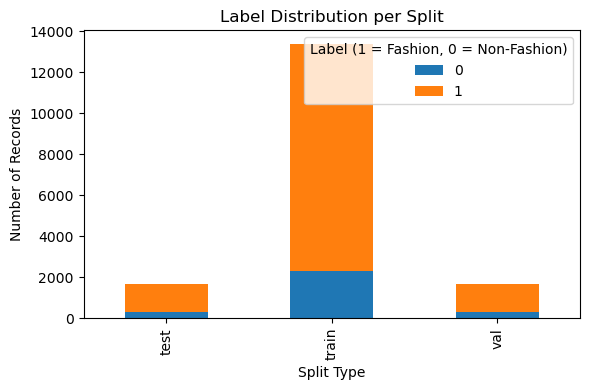

In [16]:
import matplotlib.pyplot as plt

# Count labels within each split
split_counts = df_split.groupby(['split_type', 'relevant_code_binary']).size().unstack()

# Plot stacked bar chart
split_counts.plot(kind='bar', stacked=True, figsize=(6, 4))
plt.title("Label Distribution per Split")
plt.xlabel("Split Type")
plt.ylabel("Number of Records")
plt.legend(title='Label (1 = Fashion, 0 = Non-Fashion)')
plt.tight_layout()
plt.show()

In [18]:
df_split.to_sql(
    'fashion_labeled_cleaned',
    engine,
    if_exists='replace',  # Use 'replace' now since we’ve just created and finalized this dataset
    index=False
)

711

In [20]:
df_split.to_csv("fashion_labeled_cleaned.csv", index=False)

In [22]:
pip install transformers datasets scikit-learn

  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
Note: you may need to restart the kernel to use updated packages.


In [24]:
from transformers import BertTokenizer

# Load the tokenizer for the BERT base model (uncased = lowercase)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize a sample to understand the format
example = df_split['cleaned_product_name'].iloc[0]
encoded = tokenizer(
    example,
    padding='max_length',       # pad to max_length
    truncation=True,            # truncate if too long
    max_length=64,              # max length of a product name
    return_tensors='pt'         # return PyTorch tensors
)

print("Original Text:", example)
print("Input IDs:", encoded['input_ids'])
print("Attention Mask:", encoded['attention_mask'])

Original Text: labakihah jeans for women women s mid waist lace up denim trousers stretch jeans flared pants bell bottom jeans for women light blue
Input IDs: tensor([[  101,  6845,  8978,  3270,  2232,  6312,  2005,  2308,  2308,  1055,
          3054,  5808, 12922,  2039, 26762, 15292,  7683,  6312, 14937,  6471,
          4330,  3953,  6312,  2005,  2308,  2422,  2630,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [26]:
from datasets import Dataset, DatasetDict

# Step 1: Split DataFrame into 3 subsets
train_df = df_split[df_split['split_type'] == 'train']
val_df = df_split[df_split['split_type'] == 'val']
test_df = df_split[df_split['split_type'] == 'test']

# Step 2: Convert pandas DataFrames to Hugging Face Datasets
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

# Step 3: Tokenization function for all rows
def tokenize_function(example):
    return tokenizer(
        example["cleaned_product_name"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

# Step 4: Apply tokenizer to each row in each split
tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Step 5: Rename your label column to 'labels' (what BERT expects)
tokenized_dataset = tokenized_dataset.rename_column("relevant_code_binary", "labels")

# Step 6: Set format to PyTorch
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Quick check
print(tokenized_dataset["train"][0])

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/1671 [00:00<?, ? examples/s]

Map:   0%|          | 0/1672 [00:00<?, ? examples/s]

{'labels': tensor(1), 'input_ids': tensor([  101,  6845,  8978,  3270,  2232,  6312,  2005,  2308,  2308,  1055,
         3054,  5808, 12922,  2039, 26762, 15292,  7683,  6312, 14937,  6471,
         4330,  3953,  6312,  2005,  2308,  2422,  2630,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


In [28]:
pip install huggingface_hub[hf_xet]

zsh:1: no matches found: huggingface_hub[hf_xet]
Note: you may need to restart the kernel to use updated packages.


In [30]:
from transformers import BertForSequenceClassification

# Load a pre-trained BERT model with a classification head on top
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,     # Binary classification: 0 or 1
)
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [32]:
!pip install --upgrade --force-reinstall transformers

  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
  Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached regex-2024.11.6-cp312-cp312-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached charset_normalizer-3.4.1-cp312-cp312-mac

In [34]:
import transformers
print(transformers.__version__)

4.51.3


In [36]:
!pip install "accelerate>=0.26.0"

In [1]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',                # Where to save model and logs
    eval_strategy='steps',                 # Evaluate more frequently to monitor overfitting
    eval_steps=500,                        # Evaluate every 500 steps
    save_strategy='steps',                 # Save model at the end of each epoch
    save_total_limit=2,                    # Only keep last 2 models to save space
    learning_rate=2e-5,
    per_device_train_batch_size=16,         
    per_device_eval_batch_size=64,
    num_train_epochs=10,                   # Train long, let early stopping cut off
    weight_decay=0.01,
    logging_dir='./logs',                  # Log directory
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True
)

# Define evaluation metrics
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

/Users/ramana/anaconda3/envs/bert_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'model' is not defined

In [48]:
print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [50]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.103700,0.074490,0.978456,0.993397,0.980449,0.986880
2,0.059500,0.058058,0.983842,0.991292,0.989138,0.990214
3,0.008700,0.066593,0.986236,0.990607,0.992759,0.991682


TrainOutput(global_step=2508, training_loss=0.06900701458837712, metrics={'train_runtime': 459.4056, 'train_samples_per_second': 87.295, 'train_steps_per_second': 5.459, 'total_flos': 1318975720519680.0, 'train_loss': 0.06900701458837712, 'epoch': 3.0})

In [52]:
test_metrics = trainer.evaluate(tokenized_dataset["test"])
print(test_metrics)

{'eval_loss': 0.07970614731311798, 'eval_accuracy': 0.9856459330143541, 'eval_precision': 0.9913169319826338, 'eval_recall': 0.9913169319826338, 'eval_f1': 0.9913169319826338, 'eval_runtime': 4.869, 'eval_samples_per_second': 343.397, 'eval_steps_per_second': 5.545, 'epoch': 3.0}


In [66]:
tokenizer.save_pretrained("./notebooks/results/checkpoint-2508")

('./notebooks/results/checkpoint-2508/tokenizer_config.json',
 './notebooks/results/checkpoint-2508/special_tokens_map.json',
 './notebooks/results/checkpoint-2508/vocab.txt',
 './notebooks/results/checkpoint-2508/added_tokens.json')

In [70]:
import os

tokenizer_path = "./notebooks/results/checkpoint-2508"
print(os.listdir(tokenizer_path))

['tokenizer_config.json', 'special_tokens_map.json', 'vocab.txt']


In [64]:
import torch
import torch.nn.functional as F

# Ambiguous product
custom_name = "fashion book for kids"

# Clean the name
def clean_product_name(text):
    import re
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

cleaned_name = clean_product_name(custom_name)
print(f"Cleaned name: {cleaned_name}")

# Tokenize and send to CPU
encoded_input = tokenizer(
    cleaned_name,
    padding="max_length",
    truncation=True,
    max_length=64,
    return_tensors="pt"
).to("cpu")

# Move model to CPU
model.to("cpu")

# Predict
with torch.no_grad():
    output = model(**encoded_input)
    predicted_class = torch.argmax(output.logits).item()

# Get confidence
probs = F.softmax(output.logits, dim=1)
confidence = probs[0][predicted_class].item()

label_map = {0: "Not Fashion", 1: "Fashion"}
print(f"Prediction: {label_map[predicted_class]} (Confidence: {confidence:.4f})")

Cleaned name: fashion book for kids
Prediction: Fashion (Confidence: 0.9594)
